In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree

In [16]:
weight_scale = 1.2 / 100
g = 0.85

J_I = weight_scale * g
J_E = weight_scale
delay_mean = 10.0
delay_std = delay_mean * 0.6
v_ext = 0.10

excitatory_type = "Regular_Spiking"
inhibitory_type = "Fast_Spiking"

## Generate network

In [17]:
G = nx.DiGraph()

# Add 1000 nodes
for i in range(1000):
    G.add_node(i)

# Assign 800 nodes as excitatory and 200 as inhibitory
# excitatory_nodes = random.sample(range(1000), 800)
for i in range(800):
        G.nodes[i]['inhibitory'] = False
        G.nodes[i]['ntype'] = excitatory_type
        G.nodes[i]['layer'] = 0

for i in range(800, 1000):
        G.nodes[i]['inhibitory'] = True
        G.nodes[i]['ntype'] = inhibitory_type
        G.nodes[i]['layer'] = 0

# For each node, draw 100 outgoing edges to random nodes
for i in range(1000):
    targets = random.sample(range(1000), 100)
    for target in targets:
        if G.nodes[i]['inhibitory']:
            weight = J_I
        else:
            weight = J_E
        delay = max(0.1, np.random.normal(delay_mean, delay_std))
        G.add_edge(i, target, weight=weight, distance=delay)

## Simulation setup

In [18]:
dt = 0.5

In [19]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = [excitatory_type, inhibitory_type]
n_neuron_types = len(neuron_types)
inhibitory = [False, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [20]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

## Simulation

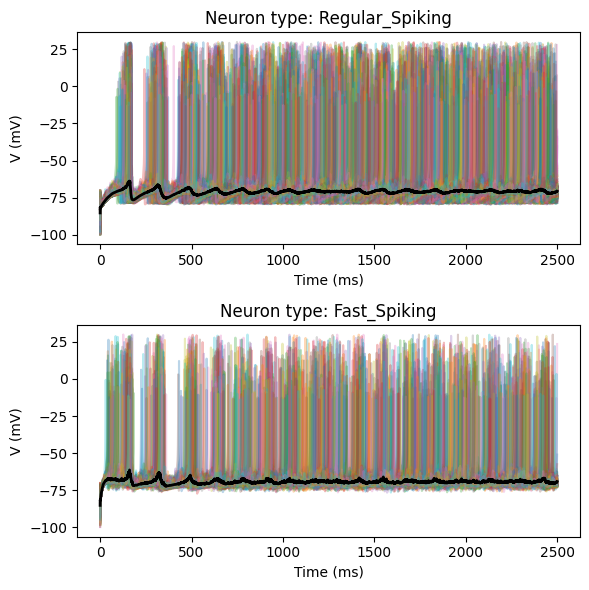

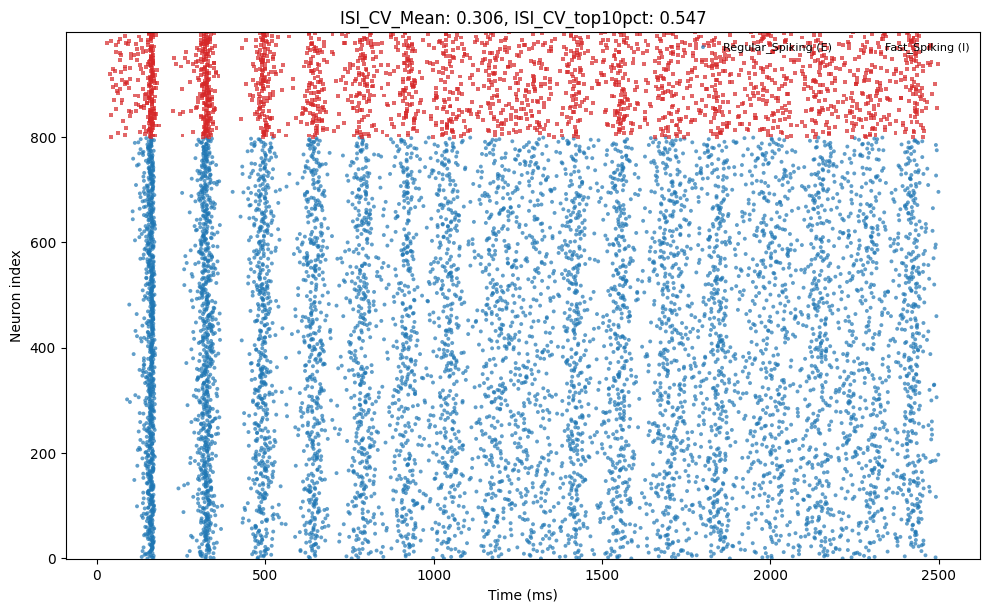

In [ ]:

# Randomize initial voltages
Vs = np.random.uniform(-100, -70, size=n_neurons)
us = np.random.uniform(0, 400, size=n_neurons) * 0
spikes = np.zeros(n_neurons, dtype=bool)
Ts = np.zeros_like(spikes)

state0 = (Vs,
          us,
          spikes.copy(),
          Ts.copy())

sim = Simulation(connectome, dt, stepper_type="simple", state0=state0,
                 enable_plasticity=True)
# sim = Simulation(connectome, dt, stepper_type="euler_det")

# rate = np.zeros(n_neurons)
poisson = PoissonInput(n_neurons, rate=v_ext, amplitude=0.03)

for i in range(5000):
    sensory_spikes = poisson(dt)
    # I_ext = np.zeros(n_neurons)
    # random_neuron = np.random.randint(0, n_neurons)
    # I_ext[random_neuron] = 2000.0
    sim.step(spike_ext=sensory_spikes)
    # sim.step(I_ext=I_ext)

sim.plot_voltage_per_type(figsize=(6, 6))

import time
time_start = time.time()


stats = sim.stats.compute_metrics(dt, bin_ms_participation=300)

isi_mean = stats['ISI_CV_mean']
isi_top = stats["ISI_CV_mean_top10pct"]

sim.plot_spike_raster(figsize=(10, 6), title=f"ISI_CV_Mean: {isi_mean:.3f}, ISI_CV_top10pct: {isi_top:.3f}")

In [22]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *